## Work
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [17]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [18]:
train, test = keras.datasets.cifar10.load_data()

In [19]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [20]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [21]:
import numpy as np

a = np.arange(50000)
np.random.shuffle(a)
indexs = a[:5000]

x_train = x_train[indexs]
y_train = y_train[indexs]

In [22]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [23]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

## 試比較 save_best_only 與否的差異

In [24]:
"""
# 載入 Callbacks, 並將監控目標設為 validation loss, 且只存最佳參數時的模型
"""
from keras.callbacks import ModelCheckpoint

def create_model_ckpt(save_best_only):

    model_ckpt = ModelCheckpoint(filepath="./tmp_{}.h5".format(save_best_only), 
                                 monitor="val_loss", 
                                 save_best_only=save_best_only)
    return model_ckpt



results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for save_best_only in [True, False]:
    try:
        keras.backend.clear_session() # 把舊的 Graph 清掉
    except:
        pass

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model_ckpt = create_model_ckpt(save_best_only)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[model_ckpt]
             )

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]

    # Load back
    model = keras.models.load_model("./tmp_{}.h5".format(save_best_only))
    loss_loadback, acc_loadback = model.evaluate(x_test, y_test)
    
    exp_name_tag = "exp-{save_best_only}".format(save_best_only=save_best_only)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc,
                            'loss_loadback':loss_loadback,
                            'acc_loadback':acc_loadback}

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512 

Epoch 47/50
5000/5000 [==============================] - 1s 205us/step - loss: 0.5150 - accuracy: 0.9116 - val_loss: 1.8353 - val_accuracy: 0.3600
Epoch 48/50
5000/5000 [==============================] - 1s 209us/step - loss: 0.5001 - accuracy: 0.9182 - val_loss: 1.8317 - val_accuracy: 0.3607
Epoch 49/50
5000/5000 [==============================] - 1s 194us/step - loss: 0.4882 - accuracy: 0.9210 - val_loss: 1.8269 - val_accuracy: 0.3633
Epoch 50/50
10000/10000 [==============================] - 1s 98us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
________

5000/5000 [==============================] - 1s 225us/step - loss: 0.5845 - accuracy: 0.8838 - val_loss: 1.8229 - val_accuracy: 0.3529
Epoch 43/50
5000/5000 [==============================] - 1s 214us/step - loss: 0.5679 - accuracy: 0.8926 - val_loss: 1.8172 - val_accuracy: 0.3544
Epoch 44/50
5000/5000 [==============================] - 1s 214us/step - loss: 0.5541 - accuracy: 0.8970 - val_loss: 1.8127 - val_accuracy: 0.3578
Epoch 45/50
5000/5000 [==============================] - 1s 230us/step - loss: 0.5398 - accuracy: 0.9062 - val_loss: 1.8109 - val_accuracy: 0.3569
Epoch 46/50
5000/5000 [==============================] - 1s 214us/step - loss: 0.5252 - accuracy: 0.9126 - val_loss: 1.8065 - val_accuracy: 0.3570
Epoch 47/50
5000/5000 [==============================] - 1s 230us/step - loss: 0.5094 - accuracy: 0.9170 - val_loss: 1.8056 - val_accuracy: 0.3575
Epoch 48/50
5000/5000 [==============================] - 1s 207us/step - loss: 0.4982 - accuracy: 0.9172 - val_loss: 1.8028 - val_

In [ ]:
model = keras.models.load_model("./tmp_{}.h5".format(True))

In [ ]:
model = keras.models.load_model("./tmp_{}.h5".format(True))

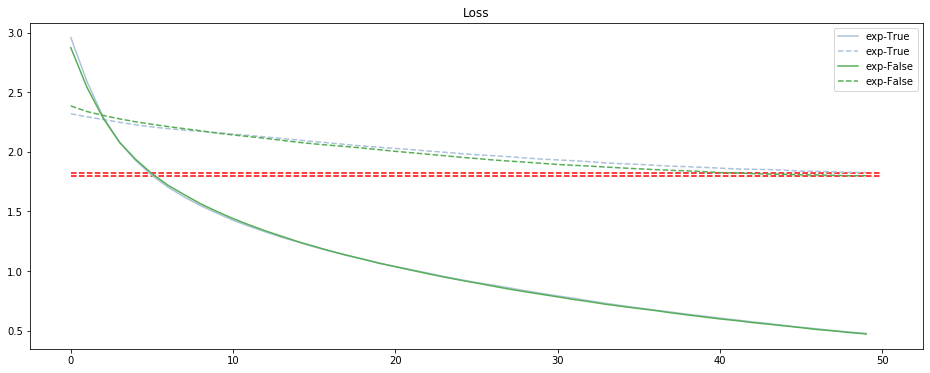

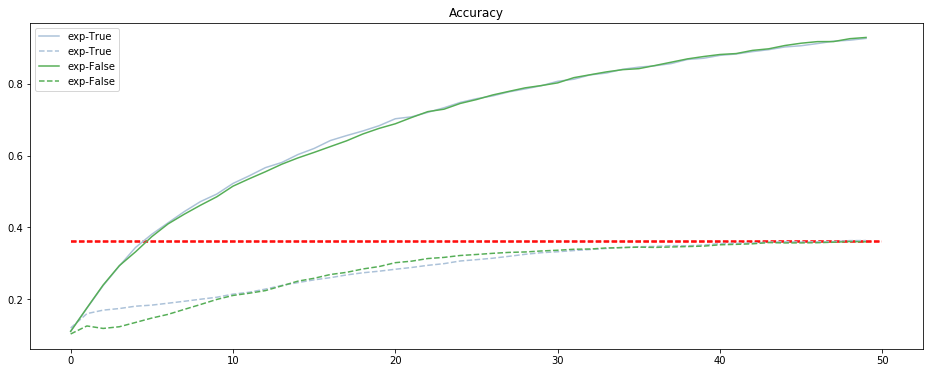

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.colors as colors
color_bar = list(colors._colors_full_map.values())

plt.figure(figsize=(16,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
    plt.hlines(y=results[cond]['loss_loadback'], xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.title("Loss")

plt.legend()
plt.show()

plt.figure(figsize=(16,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
    plt.hlines(y=results[cond]['acc_loadback'], xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.title("Accuracy")
plt.legend()
plt.show()

請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [37]:
try:
    keras.backend.clear_session() # 把舊的 Graph 清掉
except:
    pass


model_ckpt = ModelCheckpoint(filepath="./tmp_{name}.h5".format(name = 'save_weights_only_true'), 
                                 monitor="val_loss", 
                                 save_weights_only=True)
    
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[model_ckpt]
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]



Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512 

Epoch 47/50
5000/5000 [==============================] - 1s 253us/step - loss: 0.4987 - accuracy: 0.9184 - val_loss: 1.8259 - val_accuracy: 0.3594
Epoch 48/50
5000/5000 [==============================] - 1s 232us/step - loss: 0.4857 - accuracy: 0.9236 - val_loss: 1.8216 - val_accuracy: 0.3622
Epoch 49/50
5000/5000 [==============================] - 1s 258us/step - loss: 0.4737 - accuracy: 0.9262 - val_loss: 1.8194 - val_accuracy: 0.3639
Epoch 50/50
5000/5000 [==============================] - 1s 222us/step - loss: 0.4591 - accuracy: 0.9308 - val_loss: 1.8185 - val_accuracy: 0.3625


In [36]:
# Load back
model = build_mlp(input_shape=x_train.shape[1:])
model.load_weights("tmp_save_weights_only_true.h5")


optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
# model = keras.models.load_weights("tmp_save_weights_only_true.h5")
loss_loadback, acc_loadback = model.evaluate(x_test, y_test)


10000/10000 [==============================] - 2s 187us/step


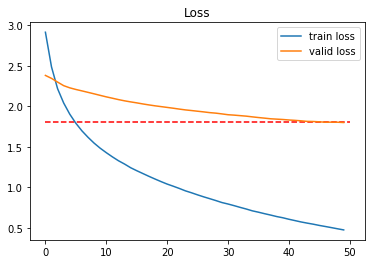

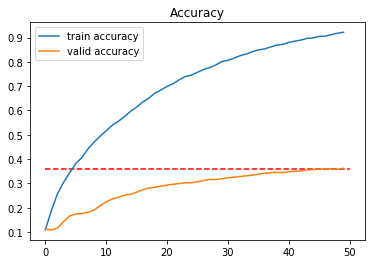

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.hlines(y=loss_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Accuracy")
plt.show()